In [1]:
from hsl_leap.leap_hand import LeapHand, LeapHandConfig, MJ_ZERO_POSITION
import time
import numpy as np
import os
import pickle

/home/ianchuang/Projects/hsl_leap/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------------------------------
# Start configuration (ALL joints)
# -------------------------------------------------
start_cfg = {
    "if_mcp": 0.0,
    "if_rot": 0.0,
    "if_pip": 0.0,
    "if_dip": 0.0,
    "mf_mcp": 0.0,
    "mf_rot": 0.0,
    "mf_pip": 0.0,
    "mf_dip": 0.0,
    "rf_mcp": 0.0,
    "rf_rot": 0.0,
    "rf_pip": 0.0,
    "rf_dip": 0.0,
    "th_cmc": 0.0,
    "th_axl": 0.0,
    "th_mcp": 0.0,
    "th_ipl": 0.0,
}

# -------------------------------------------------
# Control configuration (ONLY controlled joints)
# -------------------------------------------------
ctrl_cfg = {
    "if_mcp": {"low": 0.0, "high": 1.0},
    # "if_pip": {"low": 0.0, "high": 0.8},
    # "if_dip": {"low": 0.0, "high": 0.8},
}

In [3]:
hand = LeapHand(
        LeapHandConfig(
            port="/dev/ttyDXL_leap_hand",
            use_mj_motor_config=True,
        )
    )
hand.connect()

In [4]:
# -------------------------------------------------
# Create control signal
# -------------------------------------------------
def rollout_hand(hand, ctrl_cfg, start_cfg, duration, timestep, freq):
    n_steps = int(duration / timestep)
    t = np.arange(n_steps) * timestep
    ctrl = np.zeros((n_steps, 16))

    ctrl = {}
    for joint_name, cfg in ctrl_cfg.items():
        start = start_cfg[joint_name]
        low = cfg["low"]
        high = cfg["high"]
        if not (low <= start <= high):
            raise ValueError(f"Start position {start} for {joint_name} is out of bounds [{low}, {high}]")
        if low == high:
            ctrl[joint_name] = np.full(n_steps, low)
            continue

        # Sine wave between low and high
        amplitude = 0.5 * (high - low)
        offset = 0.5 * (high + low)

        # Phase so it starts at initial joint position
        phase = np.arcsin(np.clip((start - offset) / amplitude, -1.0, 1.0))

        ctrl[joint_name] = offset + amplitude * np.sin(
            2 * np.pi * freq * t + phase
        )

    sensor = {k: [] for k in start_cfg.keys()}
    sensor_time = []
    ctrl_time = []

    start_time = time.perf_counter()
    for i in range(n_steps):
        loop_time = time.perf_counter()

        actions = {f"{k}.pos": np.rad2deg(ctrl[k][i]) for k in ctrl_cfg.keys()}
        ctrl_time.append(time.perf_counter() - start_time)
        hand.send_action(actions)

        sensor_time.append(time.perf_counter() - start_time)
        obs = hand.get_observation()
        for k in sensor.keys():
            sensor[k].append(np.deg2rad(obs[f"{k}.pos"]))
        

        elapsed = time.perf_counter() - loop_time
        if elapsed > timestep:
            print(f"Warning: control loop is running behind schedule by {elapsed - timestep:.3f} seconds.")
        time.sleep(max(0.0, timestep - elapsed))

    sensor = {k: np.array(v) for k, v in sensor.items()}
    sensor_time = np.array(sensor_time)
    ctrl_time = np.array(ctrl_time)
    return ctrl_time, ctrl, sensor_time, sensor

In [5]:
actions = {f"{k}.pos": np.rad2deg(v) for k, v in start_cfg.items()}
hand.move(actions, duration=1.0)
t, ctrl, sensor_time, sensor = rollout_hand(
    hand=hand,
    ctrl_cfg=ctrl_cfg,
    start_cfg=start_cfg,
    duration=1.0,
    timestep=0.005,
    freq=0.5,
)

In [6]:
def record_each_joint(hand, duration=5.0, timestep=0.005, freq=0.3, save_path="outputs/traj"):

    os.makedirs(save_path, exist_ok=True)

    def record_joint(joint_name, low, high, start_cfg):
        ctrl_cfg = {k: {"low": v, "high": v} for k, v in start_cfg.items()}
        ctrl_cfg[joint_name] = {"low": low, "high": high}
        actions = {f"{k}.pos": np.rad2deg(v) for k, v in start_cfg.items()}
        hand.move(actions, duration=1.0)
        time.sleep(0.2)
        hand.send_action(actions)
        init_qpos = hand.get_observation()
        init_qpos = {k[:-4]: np.deg2rad(v) for k, v in init_qpos.items()}
        t, ctrl, sensor_time, sensor = rollout_hand(hand, ctrl_cfg, start_cfg, duration, timestep, freq)
        with open(f"{save_path}/{joint_name}_trajectory.pkl", "wb") as f:
            pickle.dump({
                "t": t,
                "ctrl": ctrl,
                "sensor_time": sensor_time,
                "sensor": sensor,
                "init_qpos": init_qpos,
                "sys_id_joints": [joint_name],
                "duration": duration,
                "timestep": timestep,
                "freq": freq,
            }, f)
        print(f"Recorded trajectory for {joint_name}.")
        hand.move(actions, duration=1.0)

    start_cfg = {
        "if_mcp": 0.0,
        "if_rot": 0.0,
        "if_pip": 0.0,
        "if_dip": 0.0,
        "mf_mcp": 0.0,
        "mf_rot": 0.0,
        "mf_pip": 0.0,
        "mf_dip": 0.0,
        "rf_mcp": 0.0,
        "rf_rot": 0.0,
        "rf_pip": 0.0,
        "rf_dip": 0.0,
        "th_cmc": 0.0,
        "th_axl": 0.0,
        "th_mcp": 0.0,
        "th_ipl": 0.0,
    }

    for prefix in ["if", "mf", "rf"]:
        record_joint(f"{prefix}_mcp", low=0.0, high=2.0, start_cfg=start_cfg)
        start = start_cfg.copy() 
        start[f"{prefix}_mcp"] = 1.0
        record_joint(f"{prefix}_rot", low=-1.0, high=1.0, start_cfg=start)
        record_joint(f"{prefix}_pip", low=-0.2, high=1.8, start_cfg=start_cfg)
        record_joint(f"{prefix}_dip", low=0.0, high=2.0, start_cfg=start_cfg)

    record_joint("th_cmc", low=0.0, high=2.0, start_cfg=start_cfg)
    start = start_cfg.copy() 
    start["th_cmc"] = 1.57
    record_joint("th_axl", low=-0.3, high=1.7, start_cfg=start)
    record_joint("th_mcp", low=-0.47, high=1.53, start_cfg=start)
    record_joint("th_ipl", low=-0.5, high=1.5, start_cfg=start_cfg)
        
        

In [7]:
record_each_joint(hand, duration=5.0, timestep=0.02, freq=0.5)

Recorded trajectory for if_mcp.
Recorded trajectory for if_rot.
Recorded trajectory for if_pip.
Recorded trajectory for if_dip.
Recorded trajectory for mf_mcp.
Recorded trajectory for mf_rot.
Recorded trajectory for mf_pip.
Recorded trajectory for mf_dip.
Recorded trajectory for rf_mcp.
Recorded trajectory for rf_rot.
Recorded trajectory for rf_pip.
Recorded trajectory for rf_dip.
Recorded trajectory for th_cmc.
Recorded trajectory for th_axl.
Recorded trajectory for th_mcp.
Recorded trajectory for th_ipl.


In [8]:
start_cfg = {
    "if_mcp": 0.0,
    "if_rot": 0.0,
    "if_pip": 0.0,
    "if_dip": 0.0,
    "mf_mcp": 0.0,
    "mf_rot": 0.0,
    "mf_pip": 0.0,
    "mf_dip": 0.0,
    "rf_mcp": 0.0,
    "rf_rot": 0.0,
    "rf_pip": 0.0,
    "rf_dip": 0.0,
    "th_cmc": 0.0,
    "th_axl": 0.0,
    "th_mcp": 0.0,
    "th_ipl": 0.0,
}
ctrl_cfg = {k: {"low": v, "high": v} for k, v in start_cfg.items()}
ctrl_cfg["if_mcp"] = {"low": 0.0, "high": 1.0}
ctrl_cfg["if_pip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["if_dip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["mf_mcp"] = {"low": 0.0, "high": 1.0}
ctrl_cfg["mf_pip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["mf_dip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["rf_mcp"] = {"low": 0.0, "high": 1.0}
ctrl_cfg["rf_pip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["rf_dip"] = {"low": 0.0, "high": 0.8}
ctrl_cfg["th_cmc"] = {"low": 0.0, "high": 1.5}
ctrl_cfg["th_axl"] = {"low": -0.3, "high": 0.7}
ctrl_cfg["th_mcp"] = {"low": -0.3, "high": 0.3}
ctrl_cfg["th_ipl"] = {"low": -0.5, "high": 0.5}
sys_id_joints = [
    "if_mcp", "if_pip", "if_dip",
    "mf_mcp", "mf_pip", "mf_dip",
    "rf_mcp", "rf_pip", "rf_dip",
    "th_cmc", "th_axl", "th_mcp", "th_ipl",
]
duration = 10.0
timestep = 0.02
freq = 0.5
actions = {f"{k}.pos": np.rad2deg(v) for k, v in start_cfg.items()}
hand.move(actions, duration=1.0)
time.sleep(0.2)
hand.send_action(actions)
init_qpos = hand.get_observation()
init_qpos = {k[:-4]: np.deg2rad(v) for k, v in init_qpos.items()}
t, ctrl, sensor_time, sensor = rollout_hand(hand, ctrl_cfg, start_cfg, duration, timestep, freq)
with open(f"outputs/traj/full_trajectory.pkl", "wb") as f:
    pickle.dump({
        "t": t,
        "ctrl": ctrl,
        "sensor_time": sensor_time,
        "sensor": sensor,
        "init_qpos": init_qpos,
        "sys_id_joints": sys_id_joints,
        "duration": duration,
        "timestep": timestep,
        "freq": freq,
    }, f)
print(f"Recorded trajectory for full hand.")
hand.move(actions, duration=2.0)

Recorded trajectory for full hand.


In [9]:
hand.disconnect()

dict_keys(['t', 'ctrl', 'sensor_time', 'sensor', 'init_qpos', 'sys_id_joints', 'duration', 'timestep', 'freq'])


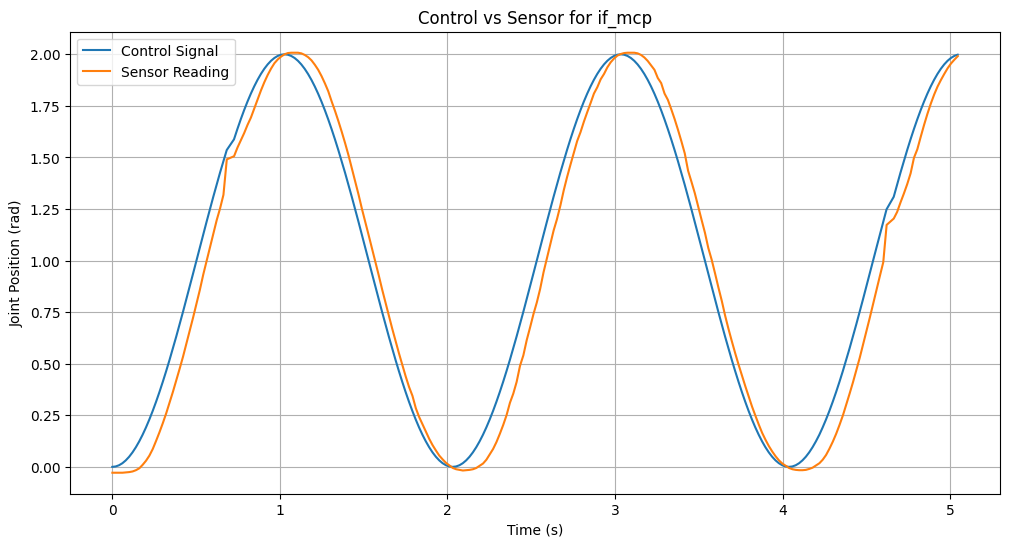

In [10]:
# load back 
joint_name = "if_mcp"
path = "/home/ianchuang/Projects/hsl_leap/sysid/outputs/traj/if_mcp_trajectory.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)
print(data.keys())

t = data["t"]
ctrl = data["ctrl"]
sensor_time = data["sensor_time"]
sensor = data["sensor"]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(t, ctrl[joint_name], label="Control Signal")
plt.plot(sensor_time, sensor[joint_name], label="Sensor Reading")

plt.title(f"Control vs Sensor for {joint_name}")
plt.xlabel("Time (s)")
plt.ylabel("Joint Position (rad)")
plt.legend()
plt.grid(True)

plt.show()
